In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import statsmodels.graphics.gofplots as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import shap

#### Read in data file

In [118]:
data = pd.read_csv("/Users/FM/Public/HDS/Summer Project/wastewater_r_estimation/all_var_dataset.csv") # 198 rows only
data.head()

,Unnamed: 0,region,date,weighted_avg_sars_cov2,gene_copies_per_day,regional_pop,weighted_average_r,temp,suspended_solids_mg_l,ammonia_mg_l,ophosph_mg_l,sample_ph_pre_ansis,control_gc_l_mean,reac_vol_control,raw_ansis_sars_repc_std,compo_frac,sars_below_lod,sars_below_loq,reception_delay
0,0,east midlands,2020-09-04,4059.005490,4.620150e+12,2845617.0,0.900000,"(235.5092972806952, 30.43365709440167, 2.52840...",235.509297,30.433657,2.528407,7.621426,9.877322e+06,2.0,2.194063,0.036872,0.000000,0.0,21.787267
1,4,east midlands,2020-09-11,19439.225934,2.212664e+13,2845617.0,1.006763,"(263.3153583212358, 63.46952102127588, 3.80986...",263.315358,63.469521,3.809870,7.621426,9.877322e+06,2.0,13.205521,0.036872,0.203796,0.0,21.790456
2,8,east midlands,2020-09-18,7492.852318,8.528715e+12,2845617.0,1.344152,"(343.27438302484137, 37.004473195092665, 3.686...",343.274383,37.004473,3.686831,7.621426,9.877322e+06,2.0,7.036485,0.036872,0.000000,0.0,21.813194
3,12,east midlands,2020-09-25,10268.071829,1.168760e+13,2845617.0,1.347104,"(233.859240368609, 35.2568550159772, 3.4671746...",233.859240,35.256855,3.467175,7.621426,9.877322e+06,2.0,6.462055,0.036872,0.383446,0.0,21.050134
4,16,east midlands,2020-10-02,27035.907485,3.077354e+13,2845617.0,1.348287,"(270.10038596198996, 37.06741033666864, 3.3799...",270.100386,37.067410,3.379940,7.621426,9.877322e+06,2.0,44.487978,0.036872,0.383446,0.0,21.674032


#### Univariable XGBoost Regressor

In [119]:
x = data.iloc[:, 3] # log weighted average RNA level
y = data.iloc[:, 6] # weighted R estimate avg

In [120]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
# 80% data for training and 20% for test, to follow previous paper setting (default 25% for test)

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.05, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

xgbr = XGBRegressor(seed = 20)

clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=50,
                         cv=5,
                         verbose=1,
                         return_train_score=True,
                         random_state=42)

# xg_reg = XGBRegressor(object='reg:squarederror')

In [123]:
clf.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                   n_iter=50,
                   param_distributions={'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': [0.05, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 6, 10, 15, 20],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=1)

In [12]:
# xg_reg.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [64]:
# Test data
# y_pred = xg_reg.predict(x_test)

y_clf = clf.predict(x_test)

In [65]:
clf.best_params_

{'subsample': 0.7,
 'n_estimators': 500,
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bytree': 0.7,
 'colsample_bylevel': 0.7}

In [66]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_clf)

In [67]:
print("MSE: %0.2f" % (mse))

MSE: 0.04


In [68]:
rmse = np.sqrt(mse)
print ("RMSE: %0.2f" % (rmse))

RMSE: 0.21


In [69]:
from sklearn.model_selection import cross_val_score
model = XGBRegressor(objective = "reg:squarederror")
scores = cross_val_score(model, x, y,
                         scoring = "neg_mean_squared_error",
                         cv = 10)

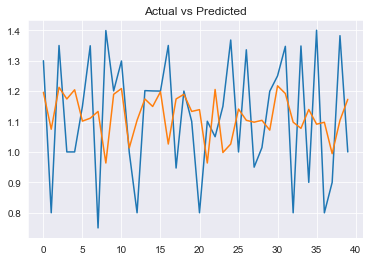

AttributeError: 'RandomizedSearchCV' object has no attribute 'get_dump'

<Figure size 432x288 with 0 Axes>

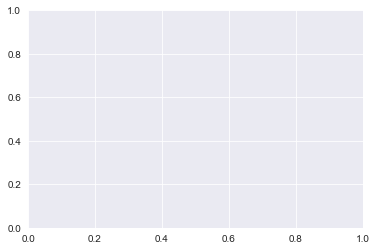

In [77]:
# Plot actual vs predicted
plt.figure()
plt.plot(list(y_test))
plt.plot(list(y_clf))
plt.title("Actual vs Predicted")
plt.show()

from xgboost import plot_tree
plt.figure()
plot_tree(clf, num_trees=0)

10

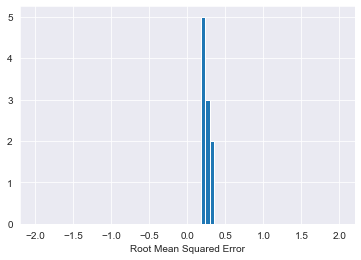

In [47]:
rmse = np.sqrt(-scores)
plt.hist(rmse, 75, range=(-2, 2))
plt.xlabel('Root Mean Squared Error')
rmse.size

In [20]:
# Plot predicted R values
y_clf

array([1.175504  , 1.1036234 , 1.1531628 , 1.0546014 , 1.1658897 ,
       1.1960026 , 1.1493144 , 1.1176854 , 1.237567  , 1.1741229 ,
       1.1496068 , 1.2624844 , 1.1741229 , 1.1278862 , 1.1324515 ,
       1.2351696 , 1.2624844 , 1.1173939 , 1.0898972 , 1.0968841 ,
       1.1154583 , 1.1126304 , 1.166651  , 1.0740116 , 1.043626  ,
       1.0888169 , 1.0898972 , 1.2181538 , 1.1292781 , 1.1555694 ,
       1.0662774 , 1.0501597 , 1.2663288 , 1.1359788 , 1.0691574 ,
       1.0531514 , 1.0455751 , 1.2019953 , 1.0635645 , 1.2681226 ,
       1.1330957 , 1.1292781 , 1.1154583 , 1.161855  , 1.0501597 ,
       1.175504  , 1.1787837 , 1.0792197 , 1.037764  , 1.2187647 ,
       1.0443981 , 1.126312  , 1.1324515 , 1.187301  , 1.1324515 ,
       1.1086509 , 1.0724388 , 1.0057468 , 1.087938  , 1.0531514 ,
       1.187301  , 1.0732139 , 1.1150471 , 1.2415366 , 1.0974656 ,
       1.1363951 , 1.2179042 , 1.1303844 , 1.1847874 , 1.2205716 ,
       1.0968841 , 1.0620875 , 1.1913569 , 1.0609392 , 1.05015

#### UKHSA Model

In [92]:
sample_variables = ['weighted_avg_sars_cov2',
                    'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l',
                    'sample_ph_pre_ansis',
                    'control_gc_l_mean', 'reac_vol_control', #"reac_vol_sars",
                    # 'raw_ansis_sars_repc_1', 'raw_ansis_sars_repc_2',
                    #'raw_ansis_sars_repc_mean',
                    'raw_ansis_sars_repc_std',
                    'compo_frac',
                    #'sars_below_lod', 'sars_below_loq',
                    'reception_delay'#,
                    #                    'ww_site_code',  # try here?
                    #                     'date',
                    #                   'analysis_lab_code',
                    #'lab_analysis_1.1.1', 'lab_analysis_1.1.2',
                    #'target_gene_N1'
                    ]

site_variables = [
    'catchment_population_ons_mid_2019',
    'catchment_area'
    #                   ,'site_skey',  # numeric so should be ok.
    #                   'ww_site_code',
    #                   'water_company_AE',
    #                   'water_company_AW', 'water_company_NW', 'water_company_ST',
    #                   'water_company_SW', 'water_company_SWS', 'water_company_TW',
    #                   'water_company_UU', 'water_company_WW', 'water_company_WXW',
    #                   'water_company_YW'
]

cis_variables = ['catch_in_cis_prop', 'catch_cis_population'
                 #             ,'cis_population'
                 ]

all_variables = sample_variables + site_variables + cis_variables

In [93]:
dict_models = dict(xgb = XGBRegressor())

model_variables = dict(xgb = sample_variables)

model_labels = {'xgb': 'Gradient Boosted'}

In [110]:
def partial_dependency(model, X, features, selected_feature):
    # The model could be an XGBoost sklearn fitted instance (or anything else with a
    # predict method)
    X_temp = X.copy()
    # Works only for numerical features. Find something else for categorical features.
    grid = np.linspace(np.percentile(X_temp.loc[:, selected_feature], 0.1),
                       np.percentile(X_temp.loc[:, selected_feature], 99.5),
                       50)
    y_pred = np.zeros(len(grid))

    for i, val in enumerate(grid):
        X_temp.loc[:, selected_feature] = val
        y_pred[i] = model.predict(X_temp.loc[:, features]).mean()

    return grid, y_pred

In [111]:
from sklearn.inspection import plot_partial_dependence

model_name = "xgb"

dataset = Dataset(df.set_index(['region', 'date']), model_variables[model_name],
                  'avg_r_avg', input_offset=0.001)
x, y = dataset.prepare_no_split()
model = dict_models[model_name]
model.fit(x, y)

# f, ax = plt.subplots(figsize=(15,15))
variables_to_plot = ['sars_cov2_gc_l_mean', 'suspended_solids_mg_l', 'ammonia_mg_l',
                     'ophosph_mg_l', 'sample_ph_pre_ansis', 'control_gc_l_mean','compo_frac',  'sars_below_loq',
                     'reception_delay', 'catchment_population_ons_mid_2019',
                     'catchment_area', 'catch_in_cis_prop'] #, 'catch_cis_population']

f, axes = plt.subplots(3, 4, figsize=(16,12), sharey=True)

for ax, selected_feature in zip(axes.flatten(), variables_to_plot):
    try:
        grid, out = partial_dependency(model, x, x.columns, selected_feature)
        ax.plot(grid, out)
        ax.set_xlabel(variable_labels[selected_feature], fontsize=15)
        ax.set_ylabel('Average R estimate', fontsize=14)
    except KeyError:
        continue
plt.tight_layout()

NameError: name 'df' is not defined

In [94]:
# Bootstrap predictions
from ml_utils import bootstrap, Dataset

repeat = 50
preds_bootstrap = {}

models = ['xgb'] # remove some models as desired, as RE can be long for example

for model_name in models:
    dataset = Dataset(data.set_index(['date']), model_variables[model_name],
                      'r_avg', input_offset=0.001) #'median_prob' refers to prevalence still
    x, y = dataset.prepare_no_split()
    preds_bootstrap[model_name] = bootstrap(dict_models[model_name], x, y, repeat=repeat)

100%|██████████| 50/50 [00:03<00:00, 15.47it/s]


In [95]:
# Computing Mean and SE of errors

dict_pred = {model_name: preds_bootstrap[model_name].mean(1) for model_name in preds_bootstrap}
# dict_pred_natural = {model_name: 10**preds_bootstrap[model_name].mean(1) for model_name in preds_bootstrap}
dict_se = {model_name: pred.std(1)/np.sqrt(repeat - np.isnan(pred).sum(1)) for model_name, pred in preds_bootstrap.items()}
dict_se_natural = {model_name: 10**pred.std(1)/np.sqrt(repeat - np.isnan(pred).sum(1)) for model_name, pred in preds_bootstrap.items()}

mean absolute error 0.0643
median absolute error 0.0539
q95 absolute error 0.1461

Natural space
median relative error 12.7871
q95 relative error 38.0941
median absolute error 13.4724
q95 absolute error 38.5799


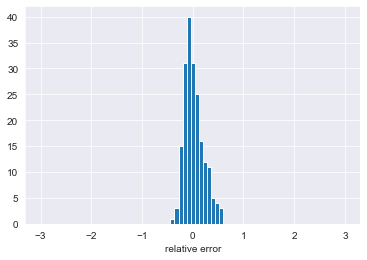

Text(0.5, 0, 'signed error (Re)')

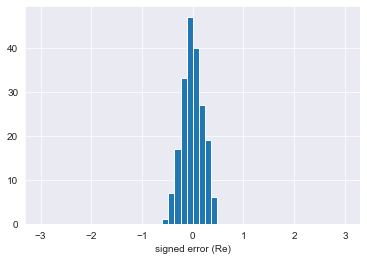

In [96]:
# Error for xgb

print(f'mean absolute error {np.abs((dict_pred[model_name]-y)).mean():.4f}')
print(f'median absolute error {np.abs((dict_pred[model_name]-y)).median():.4f}')
print(f'q95 absolute error {np.quantile(np.abs((dict_pred[model_name]-y)), 0.95):.4f}')

# Natural space
print('\nNatural space')
print(f'median relative error {np.abs((10**dict_pred[model_name]-10**y)/10**y).median()*100:.4f}')
print(f'q95 relative error {np.quantile(np.abs((10**dict_pred[model_name]-10**y)/10**y), 0.95)*100:.4f}')

print(f'median absolute error {np.abs((10**dict_pred[model_name]-10**y)).median()*100:.4f}')
print(f'q95 absolute error {np.quantile(np.abs((10**dict_pred[model_name]-10**y)), 0.95)*100:.4f}')

plt.hist((10**dict_pred[model_name]-10**y)/10**y, 75, range=(-3, 3))
plt.xlabel('relative error')
plt.show()

plt.hist((10**dict_pred[model_name]-10**y), 50, range=(-3,3))
plt.xlabel('signed error (Re)')

{'xgb':             boot_0    boot_1    boot_2    boot_3    boot_4  boot_5    boot_6  \
 date                                                                           
 2020-09-04     NaN -0.005711       NaN       NaN       NaN     NaN       NaN   
 2020-09-05     NaN       NaN -0.006803 -0.011435       NaN     NaN -0.019845   
 2020-09-06     NaN       NaN       NaN       NaN       NaN     NaN -0.019845   
 2020-09-07     NaN -0.043454       NaN       NaN       NaN     NaN       NaN   
 2020-09-08     NaN       NaN       NaN       NaN       NaN     NaN       NaN   
 ...            ...       ...       ...       ...       ...     ...       ...   
 2021-02-06     NaN       NaN  0.000294  0.089752 -0.000998     NaN       NaN   
 2021-02-07     NaN       NaN       NaN       NaN       NaN     NaN       NaN   
 2021-02-08     NaN       NaN       NaN  0.079592       NaN     NaN       NaN   
 2021-02-09     NaN       NaN       NaN       NaN       NaN     NaN       NaN   
 2021-02-10     NaN  

In [107]:
a, b = dataset.prepare_no_split()

In [109]:
a

,weighted_avg_sars_cov2,suspended_solids_mg_l,ammonia_mg_l,ophosph_mg_l,sample_ph_pre_ansis,control_gc_l_mean,reac_vol_control,raw_ansis_sars_repc_std,compo_frac,reception_delay
date,,,,,,,,,,
2020-09-04,4059.005490,2.372010,1.483368,0.403019,7.621426,6.994639,2.0,2.194063,0.036872,21.787267
2020-09-11,19439.225934,2.420478,1.802572,0.581024,7.621426,6.994639,2.0,13.205521,0.036872,21.790456
2020-09-18,7492.852318,2.535643,1.568266,0.566771,7.621426,6.994639,2.0,7.036485,0.036872,21.813194
2020-09-25,10268.071829,2.368956,1.547256,0.540101,7.621426,6.994639,2.0,6.462055,0.036872,21.050134
2020-10-02,27035.907485,2.431527,1.569004,0.529037,7.621426,6.994639,2.0,44.487978,0.036872,21.674032
...,...,...,...,...,...,...,...,...,...,...
2021-01-08,2608.493687,2.415792,1.383160,0.402095,7.403649,6.790662,2.0,1.977223,1.000000,26.417258
2021-01-15,3020.978082,2.037843,0.805519,-0.174262,7.427382,6.860543,2.0,5.281798,1.000000,25.252411
2021-01-22,891.634162,1.865933,0.767424,-0.178213,7.403649,6.790662,2.0,2.002802,0.258046,25.127548


# SHAP

In [124]:
shap_values = clf.get_feature_importance(Pool(x_test, label=y_test, cat_features=x_test) , type="ShapValues")

shap.summary_plot()

AttributeError: 'RandomizedSearchCV' object has no attribute 'get_feature_importance'